## Final Project Submission

#### Authors: Brandon Sienkiewicz, Justin James, Zach Cherna

## Overview

## Data Understanding

The first step in the process is to clean the data and retrieve as much useful information as possible. The following section details the process of cleaning the data as well as creating some additional features that prove useful for analysis.

<span style="color:red">***This notebook utilizes geopandas and contextily which are not found in our base enviroment. They can be found and installed via the links provided below:***</span>


https://anaconda.org/conda-forge/contextily

`conda install -c conda-forge contextily`

https://geopandas.org/en/stable/getting_started/install.html

`conda install geopandas`

In [2]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression


%matplotlib inline

In [3]:
df = pd.read_csv('data/kc_house_data.csv')

df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7399300360   5/24/2022  675000.0         4        1.0         1180   
1  8910500230  12/13/2021  920000.0         5        2.5         2770   
2  1180000275   9/29/2021  311000.0         6        2.0         2880   
3  1604601802  12/14/2021  775000.0         3        3.0         2160   
4  8562780790   8/24/2021  592500.0         2        2.0         1120   

   sqft_lot  floors waterfront greenbelt  ... sewer_system sqft_above  \
0      7140     1.0         NO        NO  ...       PUBLIC       1180   
1      6703     1.0         NO        NO  ...       PUBLIC       1570   
2      6156     1.0         NO        NO  ...       PUBLIC       1580   
3      1400     2.0         NO        NO  ...       PUBLIC       1090   
4       758     2.0         NO        NO  ...       PUBLIC       1120   

  sqft_basement sqft_garage sqft_patio yr_built  yr_renovated  \
0             0           0         40     1969             0   
1          1570           0        240     1950             0   
2          1580           0          0     1956             0   
3          1070         200        270     2010             0   
4           550         550         30     2012             0   

                                             address        lat       long  
0  2102 Southeast 21st Court, Renton, Washington ...  47.461975 -122.19052  
1  11231 Greenwood Avenue North, Seattle, Washing...  47.711525 -122.35591  
2  8504 South 113th Street, Seattle, Washington 9...  47.502045 -122.22520  
3  4079 Letitia Avenue South, Seattle, Washington...  47.566110 -122.29020  
4  2193 Northwest Talus Drive, Issaquah, Washingt...  47.532470 -122.07188  

[5 rows x 25 columns]

First, we import all relevant packages and read in the data. Next, we will want to get some more information about the data.

In [4]:
df_map = df.copy()

df_map['loc'] = df_map[['long','lat']].values.tolist()

geometry = [Point(tuple(xy)) for xy in df_map['loc']]

To get an idea of the geographic distribution, we will use a map which references the longitude and latitude of each listed property. The first step in the process is to create a copy of the dataframe, create a column of lists containing the longitude and latitude, and the converting it into a geometric point object.

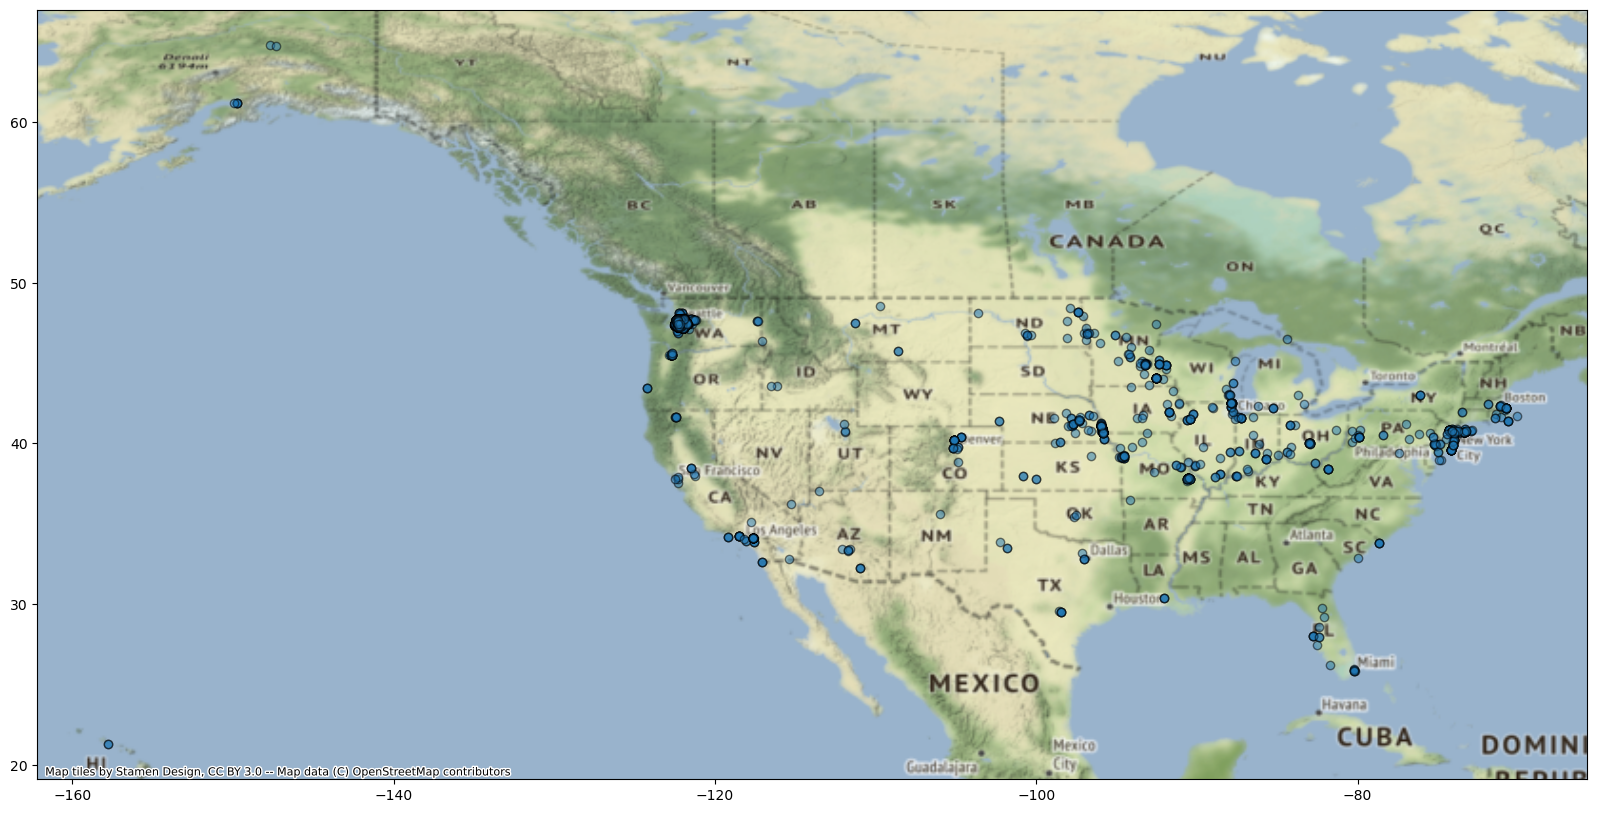

In [5]:
geo_df = gpd.GeoDataFrame(df_map,
                          crs="EPSG:4326",
                          geometry=geometry)
ax = geo_df.plot(figsize=(20, 20),
                 alpha=0.5,
                 edgecolor='k')
cx.add_basemap(ax, crs=geo_df.crs)

We then can create the GeoDataFrame and plot. We use contextily to add a basemap to our plot as well. It appears that the data provided is not limited to King County, but rather, contains home sales for areas around most of the US. It does appear that the majority of the data is within King County as there is a large clusting of points in Washington.

In [6]:
df_clean = df.dropna(inplace=True)

df_clean = df[(df.lat > 47.087) &
              (df.lat < 47.779) &
              (df.long > -122.527) &
              (df.long < -121.064)]

df_clean.reset_index(drop=True, inplace=True)

After some trial, the most efficient approach, limiting by the approximate latitude and longitude of the county, was chosen. This will give us only relevant properties. The null values are also dropped in this step.

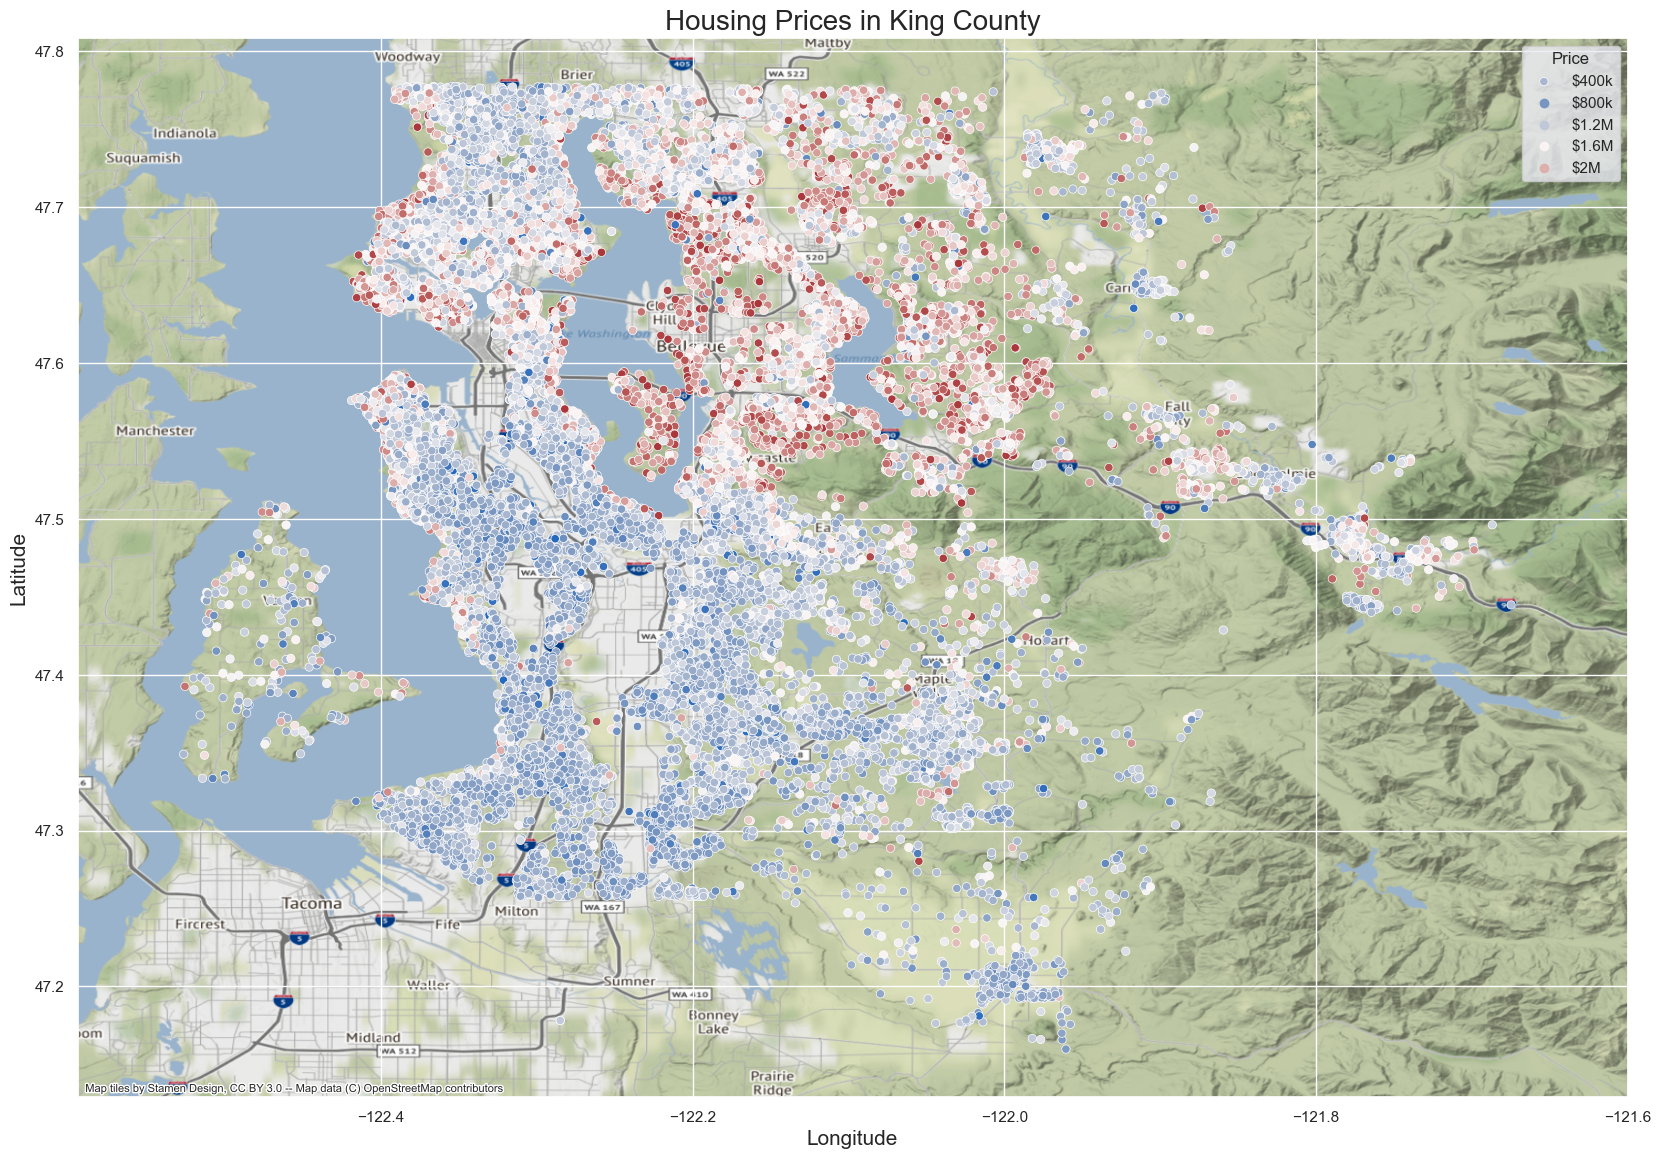

In [38]:
df_map = df_clean.copy()

sns.set(rc={'figure.figsize':(20,20)})

#Setting the figure size

df_map['loc'] = df_map[['long','lat']].values.tolist()
geometry = [Point(tuple(xy)) for xy in df_map['loc']]
geo_df = gpd.GeoDataFrame(df_map,
                          crs="EPSG:4326",
                          geometry=geometry)

#Creating the geometry point objects and the GeoDataFrame

ax = sns.scatterplot(data=geo_df,
                     x='long',
                     y='lat',
                     hue="price",
                     palette = 'vlag')

#Plotting the figure

cx.add_basemap(ax, crs=geo_df.crs)

#Adding a basemap

ax.set_xlabel('Longitude',
              fontdict={'fontsize': 15})
ax.set_ylabel('Latitude',
              fontdict={'fontsize': 15})
ax.set_title('Housing Prices in King County',
             fontdict={'fontsize': 20})
ax.legend(title='Price',
          labels=['$400k',
                  '$800k',
                  '$1.2M',
                  '$1.6M',
                  '$2M'])
plt.xlim(right=-121.6)
plt.savefig('kingcountymap', bbox_inches='tight', dpi=300);

#Labelling


# ******
# Important Note: The plot does not appear to run correctly when 
# using run all. Please re-run this cell to get the correct plot
# if all of the points are blue
# ******

This map gives us a better idea of what is going on with housing prices in King County. The higher values are represented by the red sections while the lower are represented by blue. There generally appears to be a large distribution of high value properties in one area and the value appears to diminish as you move further away from this area. Now that there is a solid understanding of our target variable, the data can begin to be cleaned.

## Data Preparation

In [9]:
df_split = df_clean.address.str.replace(',', '').str.split(' ')

The first task is to pull out the zip codes from the address listed for each property. To achieve this, commas in `df_clean.address` were replaced with empty space and then the string was split by spaces.

In [10]:
zips = []
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for x in df_split:
    for y in x:
        if (y[0] == '9') & (len(y) == 5):
            zips.append(y)
for x in zips:
    if x[1] != '8':
        zips.remove(x)
df_clean['zip'] = pd.Series(zips)

A empty list, `zips` and a list of numbers `numbers` was defined. The entries were then looped over to find entries that started with a 9 and were length 5 as this is true for all zip codes in King County. The entries were looped over once more to find entries with a second number 8 as all entries within the county contain this. Any remaining values that did not meet this final criteria were removed. The zip codes were then added to the dataframe.

In [11]:
#Creaet dict of mean prices by zip code
zips_avg_prices = df_clean.groupby(df_clean.zip).mean()['price']
zip_mean_dict = zips_avg_prices.to_dict()

# Map mean proce by zip into new column
df_clean['zip_mean'] = df_clean['zip'].map(zip_mean_dict)
df_clean['zip_mean']

# Create zip price mean category column

price_cat = []

for price in df_clean['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df_clean['price_cat'] = price_cat

With the zip codes available, the next step was to find the mean property price per zip code and to assign them to different price categories. These catergories were added to the Dataframe in the `price_cat` column.

In [12]:
# Encode ordinals
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

data_categorical = pd.DataFrame(df_clean.select_dtypes("object")) \
.drop(['date','address'],axis=1)

ordinal_data = data_categorical[['view',
                                 'condition',
                                 'grade']]

In [13]:
# Ordinal encode 'view' and create df for concat

view_ord_cats = [['NONE',
                  'FAIR',
                  'AVERAGE',
                  'GOOD',
                  'EXCELLENT']]

view_ords = OrdinalEncoder(categories=view_ord_cats)
view_ords.fit(pd.DataFrame(ordinal_data['view']))
view_encoded = view_ords.transform(pd.DataFrame(ordinal_data['view']))

view_enc = pd.DataFrame(view_encoded,
                        columns=['view_enc'])

In [14]:
# Ordinal encode 'condition' and create df for concat

condition_ord_cats = [['Poor',
                       'Fair',
                       'Average',
                       'Good',
                       'Very Good']]

cond_ords = OrdinalEncoder(categories=condition_ord_cats)
cond_ords.fit(pd.DataFrame(ordinal_data['condition']))
cond_encoded = cond_ords.transform(pd.DataFrame(ordinal_data['condition']))

cond_enc = pd.DataFrame(cond_encoded,
                        columns=['cond_enc'])

In [15]:
# Ordinal encode 'grade' and create df for concat

grade_ord_cats = [['1',
                   '2 Substandard',
                   '3 Poor',
                   '4 Low',
                   '5 Fair',
                   '6 Low Average',
                   '7 Average',
                   '8 Good',
                   '9 Better',
                   '10 Very Good',
                   '11 Excellent',
                   '12 Luxury',
                   '13 Mansion']]

grade_ords = OrdinalEncoder(categories=grade_ord_cats)
grade_ords.fit(pd.DataFrame(ordinal_data['grade']))
grade_encoded = grade_ords.transform(pd.DataFrame(ordinal_data['grade']))

grade_enc = pd.DataFrame(grade_encoded,
                         columns=['grade_enc'])

In [16]:
# Create dummy columns of non-ordinal category data

cat_data = pd.DataFrame(df_clean.select_dtypes("object")).drop(['date',
                                                                'address',
                                                                'zip'],
                                                               axis=1)

cat_dums = pd.get_dummies(cat_data)
cat_dums = cat_dums.add_suffix('_dum')

In [17]:
# Concatonate numerical and encoded features

# Concat ordinal dfs
ords_conc = pd.concat([view_enc,
                       cond_enc,
                       grade_enc],
                      axis=1)

# Get numerical data
data_numerical = df_clean._get_numeric_data()
data_numerical

#Concatonate all
concat_all = pd.concat([data_numerical,
                        ords_conc,
                        cat_dums],
                       axis=1)

# Set df to new df (concat_all)
df_clean = concat_all

In [18]:
gr_above_avg = []
for x in df_clean['grade_enc']:
    if x > 7:
        gr_above_avg.append(1)
    else:
        gr_above_avg.append(0)
        
df_clean['gr_above_avg'] = pd.Series(gr_above_avg)

To narrow down the categorical variables, grade, condition, and view were changed into binary variables (above average or not above average). This was achieved with a simple nested loop.

In [19]:
cond_above_avg = []
for x in df_clean['cond_enc']:
    if x > 2:
        cond_above_avg.append(1)
    else:
        cond_above_avg.append(0)

df_clean['cond_above_avg'] = pd.Series(cond_above_avg)   

The above code is for condition.

In [20]:
view_above_avg = []
for x in df_clean['view_enc']:
    if x > 2:
        view_above_avg.append(1)
    else:
        view_above_avg.append(0)

df_clean['view_above_avg'] = pd.Series(view_above_avg)

The above code is for view.

In [21]:
df_clean['has_garage'] = [1 if x > 0 else 0 for x in df_clean['sqft_garage']]
df_clean['has_basement'] = [1 if x > 0 else 0 for x in df_clean['sqft_basement']]
df_clean['has_patio'] = [1 if x > 0 else 0 for x in df_clean['sqft_patio']]

We also converted some housing features to binary. After some experimenting, it appears that it is more impactful if the property has the feature or not rather than looking at what the square footage of the feature is.

In [22]:
df_clean['locat'] = list(zip(df_clean.long,
                             df_clean.lat))

Another interesting feature will be the distance from the zip code highest mean price as it seems that the housing prices go down the further away from the highest price zip code one gets (represented in the map in the data understanding section. To achieve this, first we must created a tuple of longitude and latitude.

In [23]:
def haversineHighZip(coord):
    lon, lat = coord
    lonS, latS = (-122.236572, 47.626480)
    
    R = 6371000  # radius of Earth in meters
    phi = math.radians(lat)
    phi_S = math.radians(latS)
    
    delta_phi = math.radians(latS - lat)
    delta_lambda = math.radians(lonS - lon)
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi) * math.cos(phi_S) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    km = (R * c) / 1000  # output distance in kilometers

    km = round(km, 3)

    return km

We can then define the haversine function to find the distance between the zip code with the highest price and any other property. The haversine function is ideal as it is used to find the distance between two points on a sphere. Initially, we used the distance to Seattle as it is a major city in King County. After some trial and error we found that the distance to the highest priced zip code gave better results and ended up being the one chosen for the final model.

In [24]:
distance = []
for x in df_clean.locat:
    distance.append(haversineHighZip(x))
df_clean['dist_high_zip'] = pd.Series(distance)

We then use the defined haversine function to find the distance to the zip code with the highest price from each property and create a column for this information.

In [25]:
# Remove outliers

# Create function that identifies outliers

def find_outliers_IQR(df_clean):
   q1=df_clean.quantile(0.25)
   q3=df_clean.quantile(0.75)
   IQR=q3-q1
   outliers = df_clean[((df_mod<(q1-1.5*IQR)) | (df_clean>(q3+1.5*IQR)))]
   return outliers

def get_outliers(df_df_clean):
    outliers = find_outliers_IQR(df_clean)
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()))
    return print(outliers)

# Remove rows with outliers from dataframe. Currently min outliers are hard coded below after running get_outliers function

df_less_outs = df_clean[df_clean['price'] < 2309000]
df_less_outs = df_less_outs[df_less_outs['sqft_living'] < 4450]
df_less_outs = df_less_outs[df_less_outs['sqft_above'] < 3950]
df_clean = df_less_outs

Functions are defined to remove any outliers. Once the outliers are removed the only remaining step is to remove irrelevant columns that will not be used in the modelling. These were determined based on their relevance, some analysis, and some trial and error.

In [26]:
df_model = df_clean.drop([
    'id',
    'lat',
    'long',
    'view_enc',
    'waterfront_NO_dum',
    'greenbelt_NO_dum',
    'nuisance_NO_dum',
    'view_AVERAGE_dum',
    'view_EXCELLENT_dum',
    'view_FAIR_dum',
    'view_GOOD_dum',
    'view_NONE_dum',
    'condition_Average_dum',
    'condition_Fair_dum',
    'condition_Good_dum',
    'condition_Poor_dum',
    'condition_Very Good_dum',
    'grade_11 Excellent_dum',
    'grade_10 Very Good_dum',
    'grade_12 Luxury_dum',
    'grade_13 Mansion_dum',
    'grade_2 Substandard_dum',
    'grade_3 Poor_dum',
    'grade_4 Low_dum',
    'grade_5 Fair_dum',
    'grade_6 Low Average_dum',
    'grade_7 Average_dum',
    'grade_8 Good_dum',
    'grade_9 Better_dum',
    'locat'
],axis=1)
df_model.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  \
0  675000.0         4        1.0         1180      7140     1.0        1180   
1  920000.0         5        2.5         2770      6703     1.0        1570   
2  311000.0         6        2.0         2880      6156     1.0        1580   
3  775000.0         3        3.0         2160      1400     2.0        1090   
4  592500.0         2        2.0         1120       758     2.0        1120   

   sqft_basement  sqft_garage  sqft_patio  ...  \
0              0            0          40  ...   
1           1570            0         240  ...   
2           1580            0           0  ...   
3           1070          200         270  ...   
4            550          550          30  ...   

   sewer_system_PRIVATE RESTRICTED_dum  sewer_system_PUBLIC_dum  \
0                                    0                        1   
1                                    0                        1   
2                                    0                        1   
3                                    0                        1   
4                                    0                        1   

   sewer_system_PUBLIC RESTRICTED_dum  gr_above_avg  cond_above_avg  \
0                                   0             0               1   
1                                   0             0               0   
2                                   0             0               0   
3                                   0             1               0   
4                                   0             0               0   

   view_above_avg  has_garage  has_basement  has_patio  dist_high_zip  
0               0           0             0          1         18.616  
1               0           0             1          1         13.011  
2               0           0             1          0         13.863  
3               0           1             1          1          7.825  
4               0           1             1          1         16.183  

[5 rows x 37 columns]

The data has now been fully cleaned and is ready for modelling.

## Data Modelling

In [27]:
df_model.corr()['price'].map(abs).sort_values(ascending=False)[0:15]

price                  1.000000
zip_mean               0.635232
price_cat              0.600768
sqft_living            0.550074
grade_enc              0.536595
sqft_above             0.456631
gr_above_avg           0.431669
bathrooms              0.420699
dist_high_zip          0.396717
bedrooms               0.301194
sqft_patio             0.235885
sqft_garage            0.213603
floors                 0.210292
sqft_basement          0.204616
heat_source_Gas_dum    0.175061
Name: price, dtype: float64

To get an idea for a baseline model, we check the features with the highest correlation coefficient. We will use `zip_mean` for our baseline model as it has the highest correlation coefficient.

In [28]:
y = df_model['price']
X = sm.add_constant(df_clean['zip_mean'])

results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                 1.823e+04
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:36:50   Log-Likelihood:            -3.8121e+05
No. Observations:               26951   AIC:                         7.624e+05
Df Residuals:                   26949   BIC:                         7.624e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.819e+05   5285.936     53.325      0.000    2.72e+05    2.92e+05
zip_mean       0.6300      0.005    135.022      0.000       0.621       0.639
==============================================================================
Omnibus:                     2462.360   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5335.459
Skew:                           0.584   Prob(JB):                         0.00
Kurtosis:                       4.840   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The baseline model turns out to be okay. The r-squared value indicates that `zip_mean` accounts for about 40% of the variance in `price`; however, the high condition number indicates that they are likely multicollinear. This is not surprising as `zip_mean` is based on the mean prices.

In [29]:
y = df_model.price
X = sm.add_constant(df_clean
                    [[
                        'sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     7611.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:36:51   Log-Likelihood:            -3.7481e+05
No. Observations:               26951   AIC:                         7.496e+05
Df Residuals:                   26944   BIC:                         7.497e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.295e+05   8410.391     15.397      0.000    1.13e+05    1.46e+05
sqft_living          256.0461      2.488    102.901      0.000     251.169     260.923
price_cat           2.259e+05   2816.529     80.203      0.000     2.2e+05    2.31e+05
dist_high_zip      -9990.5213    180.420    -55.374      0.000   -1.03e+04   -9636.889
gr_above_avg        1.954e+05   5440.289     35.918      0.000    1.85e+05    2.06e+05
cond_above_avg      7.213e+04   3339.812     21.598      0.000    6.56e+04    7.87e+04
waterfront_YES_dum  2.402e+05   1.52e+04     15.815      0.000     2.1e+05     2.7e+05
==============================================================================
Omnibus:                     1826.565   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7715.452
Skew:                           0.203   Prob(JB):                         0.00
Kurtosis:                       5.589   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After some trial and error with models, we eventually reached the above model. This was done by starting with the feature with the highest coefficient of correlation and then iteratively adding new features. This resulted in a model with a fairly strong $r^2$ of 0.629; however, the condition number is fairly high at 19,900 which indicates there is a high amount of multicollinearity. Some feature engineering will be able to lower this number.

In [30]:
df_model['log_sqft_living'] = np.log(df_model.sqft_living)

In [31]:
y = df_model.price
X = sm.add_constant(df_model
                    [[
                        'log_sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     7216.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:36:51   Log-Likelihood:            -3.7526e+05
No. Observations:               26951   AIC:                         7.505e+05
Df Residuals:                   26944   BIC:                         7.506e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.711e+06   3.35e+04    -80.993      0.000   -2.78e+06   -2.65e+06
log_sqft_living     4.437e+05   4586.352     96.754      0.000    4.35e+05    4.53e+05
price_cat           2.273e+05   2865.436     79.333      0.000    2.22e+05    2.33e+05
dist_high_zip      -9793.3316    183.367    -53.408      0.000   -1.02e+04   -9433.922
gr_above_avg        2.455e+05   5368.080     45.734      0.000    2.35e+05    2.56e+05
cond_above_avg       6.86e+04   3395.270     20.205      0.000    6.19e+04    7.53e+04
waterfront_YES_dum  2.586e+05   1.54e+04     16.745      0.000    2.28e+05    2.89e+05
==============================================================================
Omnibus:                     2771.146   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14650.008
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       6.539   Cond. No.                         477.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By doing a log transformation of `sqft_living` we get a model with a slightly lower $r^2$ value but a much lower condition number of 477. All of the features are statistically significant as well. This indicates that there is much less multicollinearity and provides us with a strong model. Additionally, the Durbin-Watson value is slightly lower than 2 which indicates that there is only a very slight negative correlation among the errors. Since the value is so close to 2, the errors are likely independent. The only remaining step is to check our assumptions.

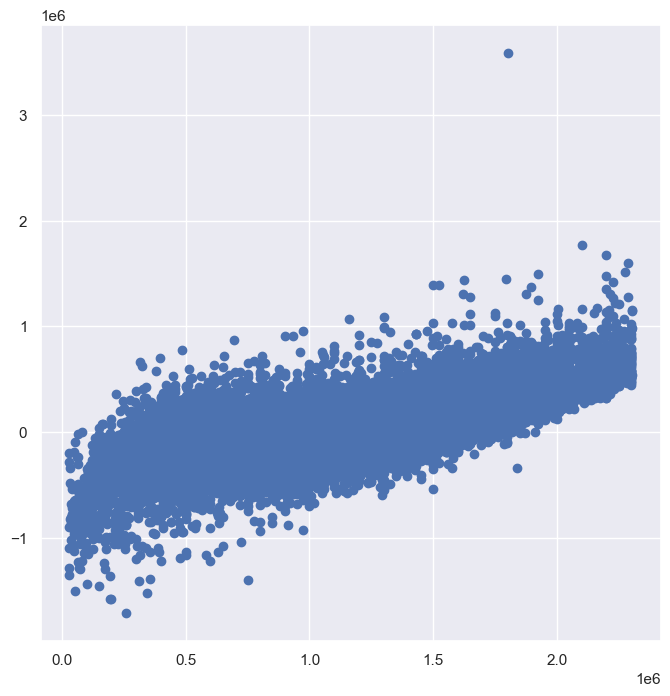

In [32]:
model_preds = model.predict(X)
resids = y - model_preds
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y, resids);

Overall, the above residual plot does not appear to be much more spread out in any section of the plot. This indicates that the data is likely homoskedastic or that the errors generally have the same variance.

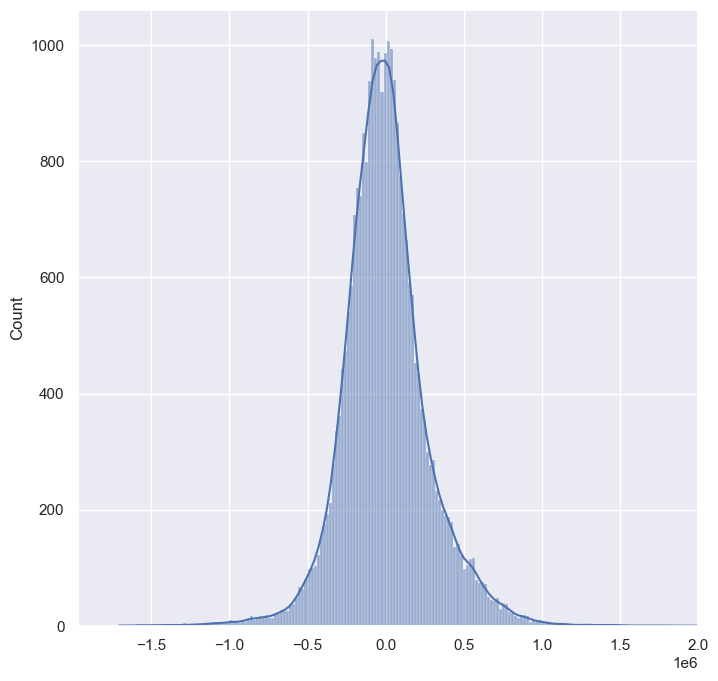

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.histplot(x=resids, kde=True)
plt.xlim(right=2000000);

After the log transformation of `sqft_living` the residuals appear to be normally distributed with a high kurtosis (~6.5 as seen in the above model).

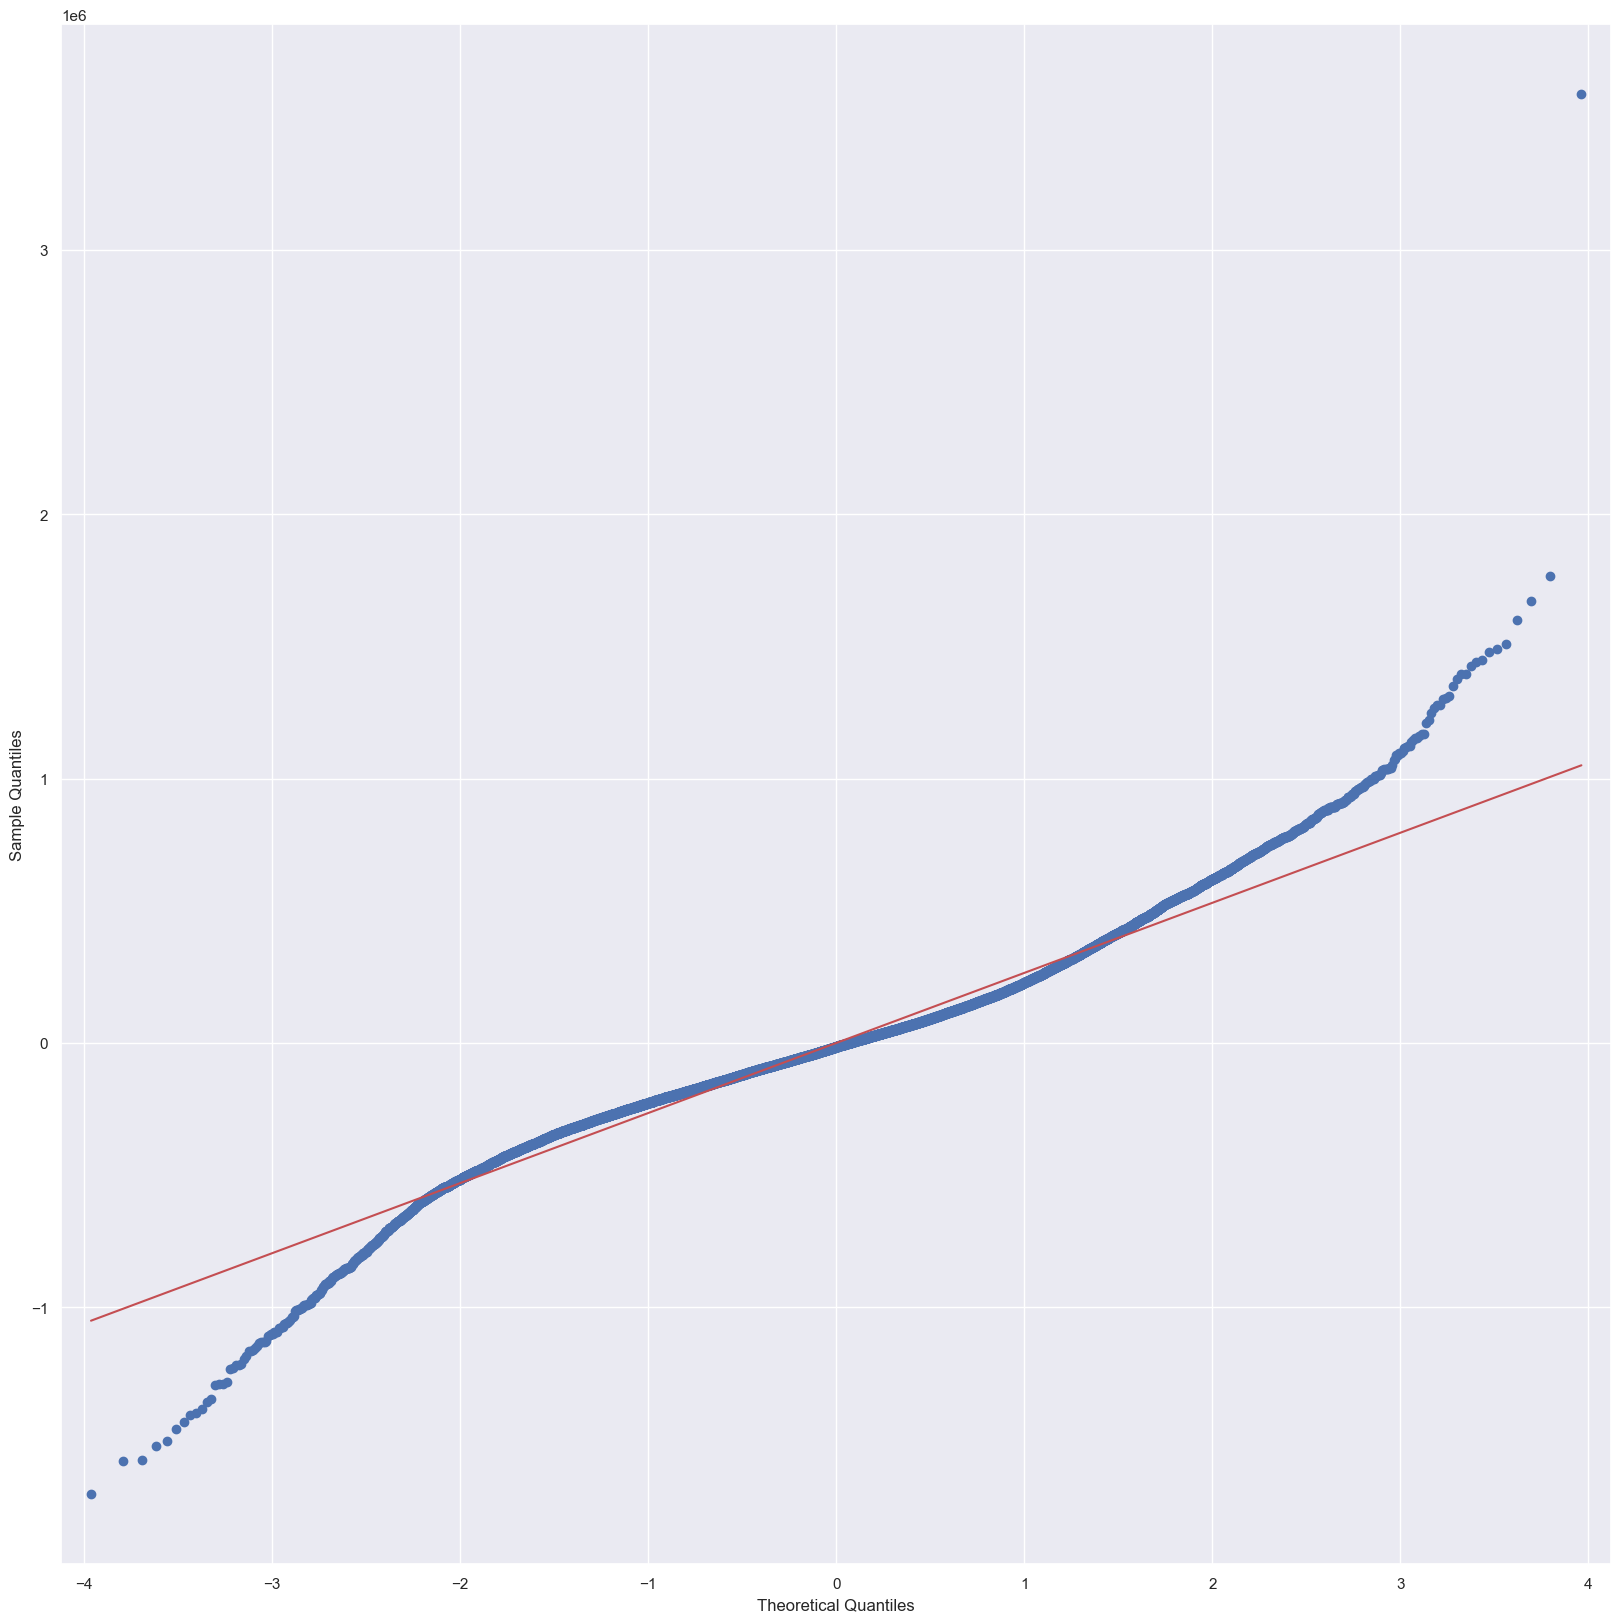

In [34]:
sm.qqplot(model.resid, line='r');

After looking at the qqplot, the tails reinforce that distribution has a high kurtosis.

In [35]:
df_final = df_model[[
    'log_sqft_living',
    'price_cat',
    'dist_high_zip',
    'gr_above_avg',
    'cond_above_avg',
    'waterfront_YES_dum']]

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif['feature'] = df_final.columns
vif["VIF"] = [variance_inflation_factor(df_final.values, i)
                          for i in range(len(df_final.columns))]

In [36]:
vif.sort_values('VIF',ascending=False)

feature        VIF
0     log_sqft_living  25.257603
1           price_cat  13.024246
2       dist_high_zip   6.093322
4      cond_above_avg   1.686581
3        gr_above_avg   1.231473
5  waterfront_YES_dum   1.023497

After looking at the variance inflation factors, it appears that `log_sqft_living` and `price_cat` are highly multicollinear features while `dist_high_zip` is fairly multicollinear. These results are not surprising as two of these values are based off of our dependent variable, `price`, and `log_sqft_living` is highly correlated with `price`.

After analysing all of the assumptions, the model appears to be pretty solid with a few minor issues (some multicollinearity and a high kurtosis). Care was taken to violate as little of the assumptions as possible and this model does a fair job of abiding to most assumptions.

While this is a good model, it does not do a great job of addressing our stakeholder. Most of the information present is not applicable to home renovations. Therefore; we sought to find another model that could help to advise renovations.

In [37]:
df_model['grade_squared'] = df_model['grade_enc']**2

y = df_model.price
X = sm.add_constant(df_model[[
    'price_cat',
    'grade_squared',
    'has_basement', 
    'has_patio', 
    'has_garage',  
    'floors',
    'bedrooms',
    'bathrooms',
    'cond_enc'
                       ]])

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     3836.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:36:52   Log-Likelihood:            -3.7705e+05
No. Observations:               26951   AIC:                         7.541e+05
Df Residuals:                   26941   BIC:                         7.542e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.544e+05   1.18e+04    -47.057      0.000   -5.77e+05   -5.31e+05
price_cat      2.967e+05   2635.948    112.561      0.000    2.92e+05    3.02e+05
grade_squared  1.182e+04    183.109     64.576      0.000    1.15e+04    1.22e+04
has_basement    3.63e+04   3778.482      9.608      0.000    2.89e+04    4.37e+04
has_patio      1.711e+04   4337.751      3.945      0.000    8608.076    2.56e+04
has_garage    -5.296e+04   4129.186    -12.825      0.000   -6.11e+04   -4.49e+04
floors        -2.397e+04   4046.444     -5.923      0.000   -3.19e+04    -1.6e+04
bedrooms       4.793e+04   2265.465     21.156      0.000    4.35e+04    5.24e+04
bathrooms      7.064e+04   3370.318     20.960      0.000     6.4e+04    7.72e+04
cond_enc       5.254e+04   2592.241     20.266      0.000    4.75e+04    5.76e+04
==============================================================================
Omnibus:                     2102.186   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5708.824
Skew:                           0.442   Prob(JB):                         0.00
Kurtosis:                       5.075   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluation

## Conclusion